# Написать программу для построения обратного индекса с учетом морфологического анализа. Необходимо реализовать возможность поиска по нескольким словам.

In [1]:
import nltk
import os
import unicodedata
import numpy as np
import regex as re
import wordcloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
from nltk import word_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Egor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
EXACT_BONUS = 2 # При точном совпадении словоформы вес целевой функции будет повышен
DATA_DIR = 'data' # Папка с файлами

all_words = [] # Массив всех слов для графика

def file_to_tokens(filename) -> list[str]:
    """
    Чтение токенов из файла

        Аргумент: 
            `filename`: Имя текстового файла

        Возвращает: 
            Список, содержащий все токены файла.
    """
    with open(filename, 'r', encoding='utf-8') as fr:
        doc = fr.readlines()
    doc = list(map(str.lower, doc))
    tokens = []
    for text in doc:
        all_words.append(text)
        for token in nltk.word_tokenize(re.sub(r'[^\w\s]','',unicodedata.normalize("NFKC",text))):
            tokens.append(token)
    return tokens

def get_wordCloud(atext) -> wordcloud:
    wordCloud = wordcloud.WordCloud(background_color = 'white',
                              width = 3000,
                              height = 2500,
                              max_words = 200,
                              random_state = 42
                         ).generate(' '.join(atext))
    return wordCloud

from matplotlib import pyplot as plt
def show_wordCloud():
    procWordCloud = get_wordCloud(all_words)
    fig = plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(procWordCloud)
    plt.axis('off')
    plt.subplot(1, 2, 1)

In [3]:
class ReverseIndex:
    """Класс для реализации обратного индекса"""

    def __init__(self, files):
        """
        Конструктор класса, принимающий список файлов для индексации
        """
        self.files = files
        self.idx_data = dict()  # Словарь для индекса в формате {слово: {форма: {файл: [позиции в файле]}}}
        
        """
        Для лемматизации используется WordNetLemmatizer из библиотеки NLTK
        """
        self.lemmatizer = WordNetLemmatizer()

        self.total_words_in_file = dict()

    def min_distance(self, word1, word2) -> int:
        """
        Функция для определения минимального расстояния между двумя словами
        """
        return min(map(lambda x, y: abs(x - y), word1, word2))

    def docs_with_word_cnt(self, word) -> int:
        """
        Функция для подсчёта количества документов, в которых встречается слово
        """
        return 0 if(word not in self.idx_data.keys()) else len(self.idx_data[word].keys())

    def force_lemmatize(self, word) -> str:
        """
        Функция для лемматизации слова
        """
        tokenw = nltk.word_tokenize(word)
        token = self.lemmatizer.lemmatize(tokenw[0])
        if( token == tokenw[0] ):
            token = self.lemmatizer.lemmatize(tokenw[0],'v')
        return token

    def word_counter(self, file, word, form_to_find) -> int:
        """
        Функция для подсчёта количества вхождений слова в документ
        """
        if word not in self.idx_data.keys():  # Если слово отсутствует в словаре индекса
            return 0
        ret = 0
        for var in self.idx_data[word].keys():  # Перебираем все формы слова, представленные в словаре
            if file in self.idx_data[word][var].keys():  # Если файл содержит данную форму слова
                ret += len(self.idx_data[word][var])  # Увеличиваем вес
                if (form_to_find == var):
                    ret += EXACT_BONUS  # Увеличиваем вес, если найдена оригинальная словоформа
        return ret

    def word_pos(self, file, word, form_to_find) -> dict():
        """
        Функция для получения позиций вхождения слова в документ
        """
        if word not in self.idx_data.keys():  # Если слово отсутствует в словаре индекса
            return 0
        wordforms = self.idx_data[word].keys()  # Получаем все формы слова
        ret = dict()
        for var in wordforms:
            if file in self.idx_data[word][var].keys():  # Если файл содержит данную форму слова
                for i in self.idx_data[word][var][file]:
                    # Заносим позиции вхождения данной формы слова в словарь
                    ret[i] = EXACT_BONUS if(form_to_find == var) else 1
        return dict(sorted(ret.items(), key=lambda item: item[1])).keys()

    def find_single_word(self, word) -> dict():
        """
        Функция для поиска документов, содержащих одно слово
        """
        word = word.lower()  # Приводим слово к нижнему регистру
        token = self.force_lemmatize(word)  # Лемматизируем слово
        tf_idfs = dict()
        for i, document in enumerate(self.files):
            # Вычисляем TF-IDF для каждого документа
            tf = self.word_counter(i, token, word) / self.total_words_in_file[i]
            tmp = self.docs_with_word_cnt(token)
            if tmp != 0: # Изюегаем деления на 0
                idf = np.log(len(self.files) / tmp)
                tfidf = tf * idf
                if tfidf != 0:
                    tf_idfs[i] = tfidf
        ret = dict()
        for i in dict(sorted(tf_idfs.items(), key=lambda item: item[1])).keys():
            # Заносим название документа и позиции вхождения слова в словарь
            ret[self.files[i]] = self.word_pos(i, token, word)
        return ret

    def find(self, *words) -> dict():
        """
        Ищем слова в файлах. Чем слова ближе друг к другу, тем лучше результат
        Если передан один аргумент - вызываем метод find_single_word()
        Если - несколько - обрабатываем внутри метода
        """
        words = [a.lower() for a in words]
        # Если передано только одно слово, вызываем соответствующий метод
        if(len(words) == 1):
            return self.find_single_word(words[0])
        lemmas = [ self.force_lemmatize(a) for a in words]  # Получаем леммы переданных слов
        results = dict()  # Инициализируем словарь результатов
        for i, document in enumerate(self.files):
            words_encountered = dict()  # Получаем все найденные слова и их вхождения в документ 
            for w in lemmas:
                if w in self.idx_data.keys():
                    words_encountered[w] = dict()
                    count = 0
                    for var in self.idx_data[w].keys():
                        if i in self.idx_data[w][var].keys():
                            words_encountered[w][var] = self.idx_data[w][var][i]
                            count += 1
                    if count == 0:
                        del words_encountered[w]
            if len(words) == len(words_encountered): # Присутствуют все слова?
                diffs = dict()
                words_to_check = np.array(list(words_encountered.keys()))
                min_dists = []
                 # Вычисляем минимальное расстояние (количество слов) между каждой парой соседних слов
                for idx in range(len(words_to_check)-1):
                    word1 = words_encountered[words_to_check[idx]]
                    for var1 in word1:
                        word2 = words_encountered[words_to_check[idx + 1]]
                        for var2 in word2:
                            word1_idxs = words_encountered[words_to_check[idx]][var1]
                            word2_idxs = words_encountered[words_to_check[idx + 1]][var2]
                            # При вычислении минимального расстояния учитываем, если слова уже присутствуют в парах
                            min_dist = self.min_distance(word1_idxs, word2_idxs)
                            if var1 == words[idx]:
                                min_dist -= 1
                            if var2 == words[idx + 1]:
                                min_dist -= 1
                            min_dists.append(min_dist)
                # Добавляем среднее минимальное расстояние для данной пары слов в результаты
                results[i] = np.mean(min_dists) / len(min_dists)
        # Сортируем документы по возрастанию значений расстояний
        relevant = (dict(sorted(results.items(), key = lambda item: item[1])).keys())
        # Инициализируем словарь с результатами
        output = dict()
        # Получаем информацию о позиции первого найденного слова в каждом документе
        for i in relevant:
            output[self.files[i]] = self.word_pos(1, self.force_lemmatize(words[0]), words[0])
        return output
    
    def run(self):
        """
        Обрабатываем каждый файл в коллекции файлов текущего индекса
        """
        for i, file in enumerate(self.files):
            words = file_to_tokens(file)
            self.total_words_in_file[i] = len(words)
            for pos, w in enumerate(words):
                # Получаем его лемму и добавляем информацию о вхождении слова в документ в индекс
                basic_form = self.force_lemmatize(w)
                if basic_form not in self.idx_data:
                    self.idx_data[basic_form] = dict()
                if w not in self.idx_data[basic_form].keys():
                    self.idx_data[basic_form][w] = dict()
                if i not in self.idx_data[basic_form][w].keys():
                    self.idx_data[basic_form][w][i] = []
                self.idx_data[basic_form][w][i].append(pos)

In [4]:
files = os.listdir('./' + DATA_DIR + '/')
files[:] = [DATA_DIR + '\\' + x for x in files]
X = ReverseIndex(files)

X.run()

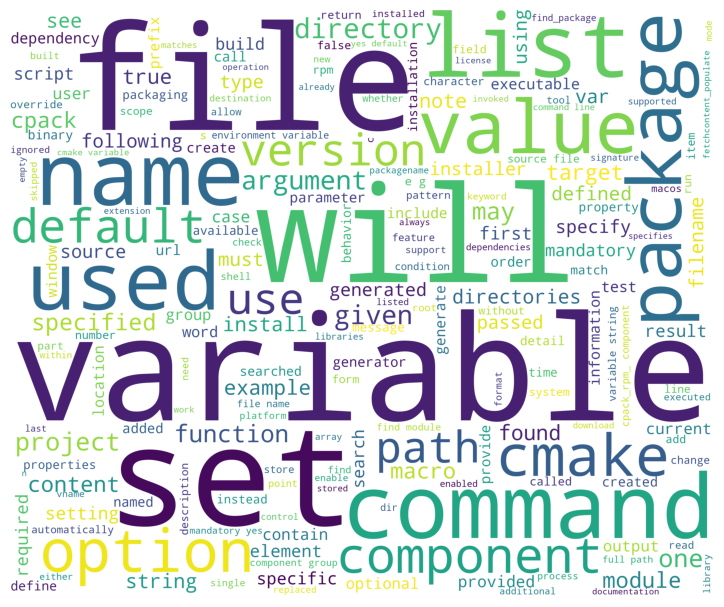

In [5]:
# Смотрим, какие слова встречающтся чаще остальных
show_wordCloud()

In [6]:
X.find('mebibyte')

{'data\\cmake-commands.txt': dict_keys([2])}

In [7]:
X.find('lexical')

{'data\\cmake-modules.txt': dict_keys([17446])}

In [8]:
X.find('Since', 'the', 'cpack')

{'data\\cpack-generators.txt': dict_keys([7928, 9719, 11031, 12940, 12985, 14527, 15528]),
 'data\\cmake-modules.txt': dict_keys([7928, 9719, 11031, 12940, 12985, 14527, 15528])}

In [9]:
X.find('first', 'line')

{'data\\ksh2020.txt': dict_keys([6421, 6576, 8546, 8803, 9099, 9661, 9816, 11165, 11270, 14529, 15323, 15569, 17678]),
 'data\\cpack-generators.txt': dict_keys([6421, 6576, 8546, 8803, 9099, 9661, 9816, 11165, 11270, 14529, 15323, 15569, 17678]),
 'data\\cmake-commands.txt': dict_keys([6421, 6576, 8546, 8803, 9099, 9661, 9816, 11165, 11270, 14529, 15323, 15569, 17678]),
 'data\\cmake-modules.txt': dict_keys([6421, 6576, 8546, 8803, 9099, 9661, 9816, 11165, 11270, 14529, 15323, 15569, 17678])}

In [10]:
X.find('debian', 'policy', 'manual')

{'data\\cpack-generators.txt': dict_keys([11783])}